# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [1]:
import os.path

In [2]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [4]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Date***

**Loading dataset**

In [5]:
# loading in the sample dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [6]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [7]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [8]:
final_number_of_columns = len(data.columns)
final_number_of_columns

105

**Train and test split**

In [9]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [19]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar_old.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<segment_a>,<segment_b>)|sub(<segment_a>,<segment_b>)|pdiv(<segment_a>,<segment_b>)|mul(<segment_a>,<segment_b>)|<decimal>|<segment_a>|add(<segment_b>,<segment_a>)|sub(<segment_b>,<segment_a>)|pdiv(<segment_b>,<segment_a>)|mul(<segment_b>,<segment_a>)|<segment_b>
<decimal> ::= <n><n>.<n><n>
<segment_a> ::= x[0]|x[1]|x[2]|x[3]|x[4]|x[5]|x[6]|x[7]|x[8]|x[9]|x[10]|x[11]|x[12]|x[13]|x[14]|x[15]|x[16]|x[17]|x[18]|x[19]|x[20]|x[21]|x[22]|x[23]|x[24]|x[25]|x[26]|x[27]|x[28]|x[29]|x[30]|x[31]|x[32]|x[33]|x[34]|x[35]|x[36]|x[37]|x[38]|x[39]|x[40]|x[41]|x[42]|x[43]|x[44]|x[45]|x[46]|x[47]|x[48]|x[49]|x[50]|x[51]
<segment_b> ::= x[52]|x[53]|x[54]|x[55]|x[56]|x[57]|x[58]|x[59]|x[60]|x[61]|x[62]|x[63]|x[64]|x[65]|x[66]|x[67]|x[68]|x[69]|x[70]|x[71]|x[72]|x[73]|x[74]|x[75]|x[76]|x[77]|x[78]|x[79]|x[80]|x[81]|x[82]|x[83]|x[84]|x[85]|x[86]|x[87]|x[88]|x[89]|x[90]|x[91]|x[92]|x[93]|x[94]|x[95]|x[96]|x[97]|x[98]|x[99]|x[100]|x[101]|x[102]|x[103]
<n> ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9


**Setup grammar**

In [20]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar_old.bnf")

         Unit productions consume GE codons.


### ***Fitness Function***

In [21]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [22]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.6
P_MUTATION = 0.2
ELITE_SIZE = round(0.1*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 10
MAX_INIT_TREE_DEPTH = 8
MIN_INIT_TREE_DEPTH = 2
MAX_TREE_DEPTH = 10
MAX_WRAPS = 0
CODON_SIZE = 255

**Creating DEAP toolbox**

In [23]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=10)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [24]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.509424	0.0145233	0.439197	0.536208	0.44133     	4              	4.795     	9         	0             	3.09816        
1  	12     	0.508886	0.0176467	0.439197	0.538349	0.537159    	4              	4.82      	13        	0.00334525    	3.03854        
2  	10     	0.513346	0.0196369	0.439197	0.538647	0.540004    	4              	5.14      	13        	0.00178289    	2.97745        
3  	11     	0.513817	0.02129  	0.439197	0.538647	0.540004    	4              	5.17      	16        	0.00180101    	3.12656        
4  	7      	0.513259	0.0217319	0.439197	0.538647	0.540004    	4              	5.205     	16        	0.00178313    	3.28794        
5  	6      	0.514098	0.0237208	0.439197	0.538647	0.540004    	4              	5.445     	12        	0.00179696    	3.35951        
6  	5      	0.513007	0.02404  	0.439197	0.538647	0.540004    	4              	5.65 

62 	0      	0.522798	0.0372294	0.438037	0.561041	0.563875    	5              	12.485    	23        	0.00176597    	3.4532         
63 	0      	0.526069	0.0374952	0.438037	0.561041	0.563875    	5              	13.065    	21        	0.00176311    	3.51548        
64 	0      	0.521555	0.0365785	0.438037	0.561041	0.563875    	5              	12.6      	20        	0.00177217    	3.41851        
65 	1      	0.52104 	0.0374354	0.438037	0.561041	0.563875    	5              	13.2      	21        	0.00177121    	3.33436        
66 	0      	0.526087	0.0377206	0.438037	0.561041	0.563875    	5              	12.755    	21        	0.00176597    	3.71146        
67 	1      	0.523335	0.0373462	0.438037	0.561041	0.563875    	5              	12.91     	22        	0.00210905    	3.44815        
68 	0      	0.525159	0.0366817	0.438037	0.561041	0.563875    	5              	12.92     	24        	0.00177097    	3.43285        
69 	0      	0.52261 	0.0370167	0.438037	0.561041	0.563875    	5              	13.49

**Statistics**

In [25]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.509424,0.014523,0.439197,0.536208,0.441330,4,4.795,9,0.000000,3.098155
1,1,12,0.508886,0.017647,0.439197,0.538349,0.537159,4,4.820,13,0.003345,3.038540
2,2,10,0.513346,0.019637,0.439197,0.538647,0.540004,4,5.140,13,0.001783,2.977446
3,3,11,0.513817,0.021290,0.439197,0.538647,0.540004,4,5.170,16,0.001801,3.126557
4,4,7,0.513259,0.021732,0.439197,0.538647,0.540004,4,5.205,16,0.001783,3.287939
5,5,6,0.514098,0.023721,0.439197,0.538647,0.540004,4,5.445,12,0.001797,3.359515
6,6,5,0.513007,0.024040,0.439197,0.538647,0.540004,4,5.650,12,0.001765,3.375196
7,7,2,0.510295,0.024999,0.439197,0.538647,0.540004,4,5.705,14,0.001765,3.403673
8,8,6,0.509259,0.025991,0.439197,0.538647,0.540004,4,5.970,12,0.001796,3.342244
9,9,6,0.512558,0.025321,0.439197,0.538647,0.540004,4,5.850,13,0.001745,3.321901


**Best individual**

In [26]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
sub(x[79],x[1])

Training Fitness:  0.5610408921933085

Depth:  3

Length of the genome:  5

Used portion of the genome: 0.60



Calculating predictions

In [10]:
x = X_test
predictions = sub(x[79],x[1])
print(predictions)

[ 3.57303276e-02  5.54394473e-02  1.20881462e-02 ...  4.35208205e+01
  3.06901145e+01 -5.02619547e-03]


Classifying predictions to labels

In [11]:
Y_prediction_class= [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print(Counter(Y_prediction_class))

Counter({1: 8516, 0: 5895})


Calculating Confusion Matrix

In [13]:
TP, FN, TN, FP = 0, 0, 0, 0
for x, y in zip(Y_test, Y_prediction_class):
  # 0 = no cancer, 1 = cancer
  if x == 0:
    if y == 0:
      TN = TN + 1
    else:
      FP = FP + 1
  elif x == 1:
    if y == 1:
      TP = TP + 1
    else:
      FN = FN + 1

Accuracy

In [14]:
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
accuracy

0.5559641940184581

True Positive Rate

In [15]:
TPR = TP/(TP+FN)
TPR

0.646911866759195

True Negative Rate

In [16]:
TNR = TN/(TN+FP)
TNR

0.4650291423813489

False Positive rate

In [17]:
FPR = FP/(FP+TN)
FPR

0.5349708576186512

False Negative Rate

In [18]:
FNR = FN/(FN+TP)
FNR

0.353088133240805

Area Under the Curve

In [19]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
auc

0.5559705045702719

**Best individuals plots**

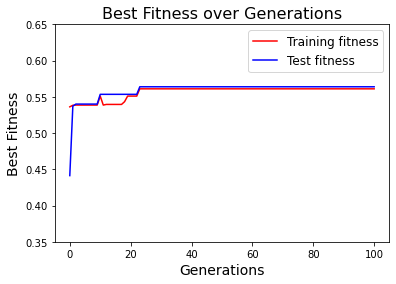

In [41]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

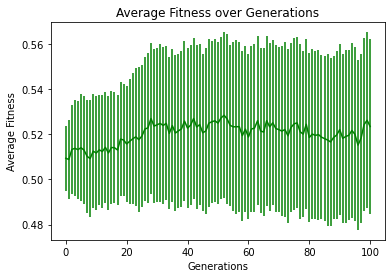

In [42]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

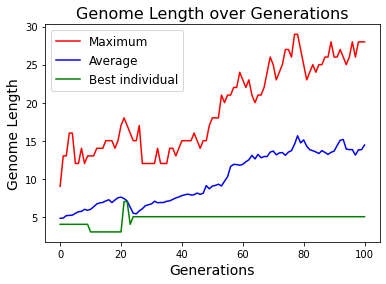

In [43]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()